# PS reconstruction, Gaussian beam

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir = os.path.join('data', 'gaussian_beam', 'normal')
p0c = 43.36e6 # reference momentum in eV/c
gt_beam = create_beam(
    base_yaml = os.path.join(yaml_dir, 'gaussian.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 1_000_000,
    save_as = os.path.join(save_dir, 'gaussian_beam.pt')
)

ground truth distribution saved at data/gaussian_beam/normal/gaussian_beam.pt


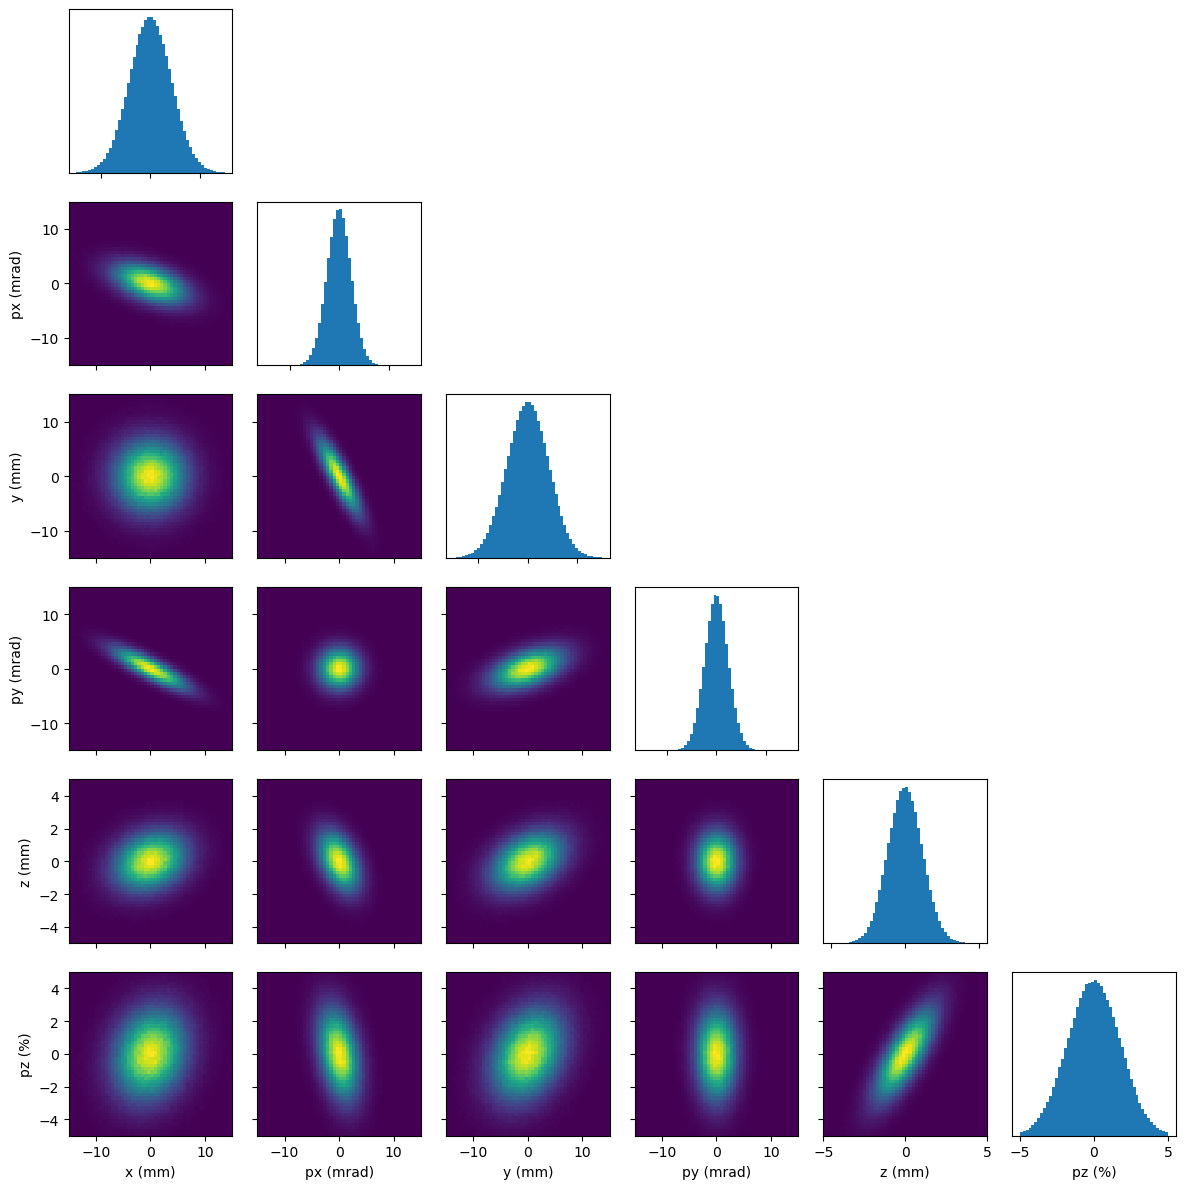

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 =    10.986991
k2 =   -24.674763
k3 =    26.907939

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 1e7]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as 'data/gaussian_beam/normal/3d_scan_train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


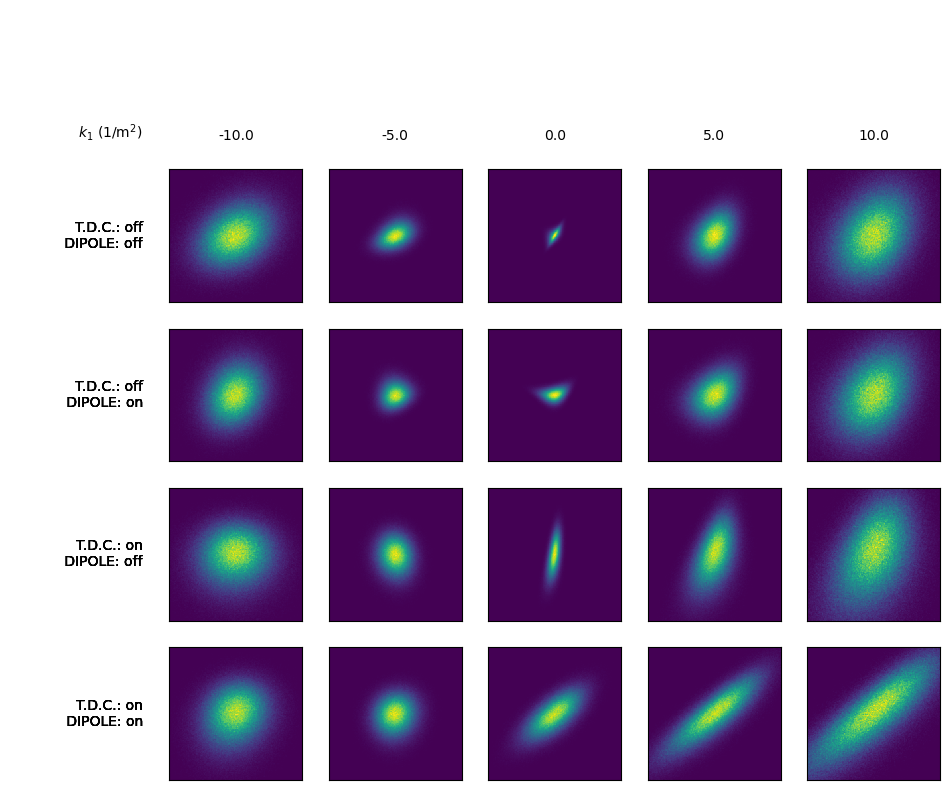

In [27]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
fig.savefig("gaussian_data.png",dpi=300)
fig.savefig("gaussian_data.svg")
plt.show()

In [8]:
%%time



# training with 4 gpus
pred_beam_3d_scan_10_000, model = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen, 
    ids = scan_ids,
    n_epochs = 3_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    lambda_=1e14,
    save_dir = save_dir,
    distribution_dump_frequency=500,
    distribution_dump_n_particles=1_000_000,
    )

Using device: cuda:0


/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1694463969407/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(3.7905e+09, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(5.2043e+08, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(4.8871e+08, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(4.1494e+08, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(4.1322e+08, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(3.9440e+08, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(4.7209e+08, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(4.4683e+08, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(4.8027e+08, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(4.1332e+08, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(4.6055e+08, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(4.1635e+08, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(4.9357e+08, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(4.9681e+08, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(4.5112e+08, device='cuda:0', grad_fn=<MulBackward0>)
1500 tensor(4.3325e+08, device='cuda:

-15 15
-15 15
-15 15
-15 15
-7 7
-5 5


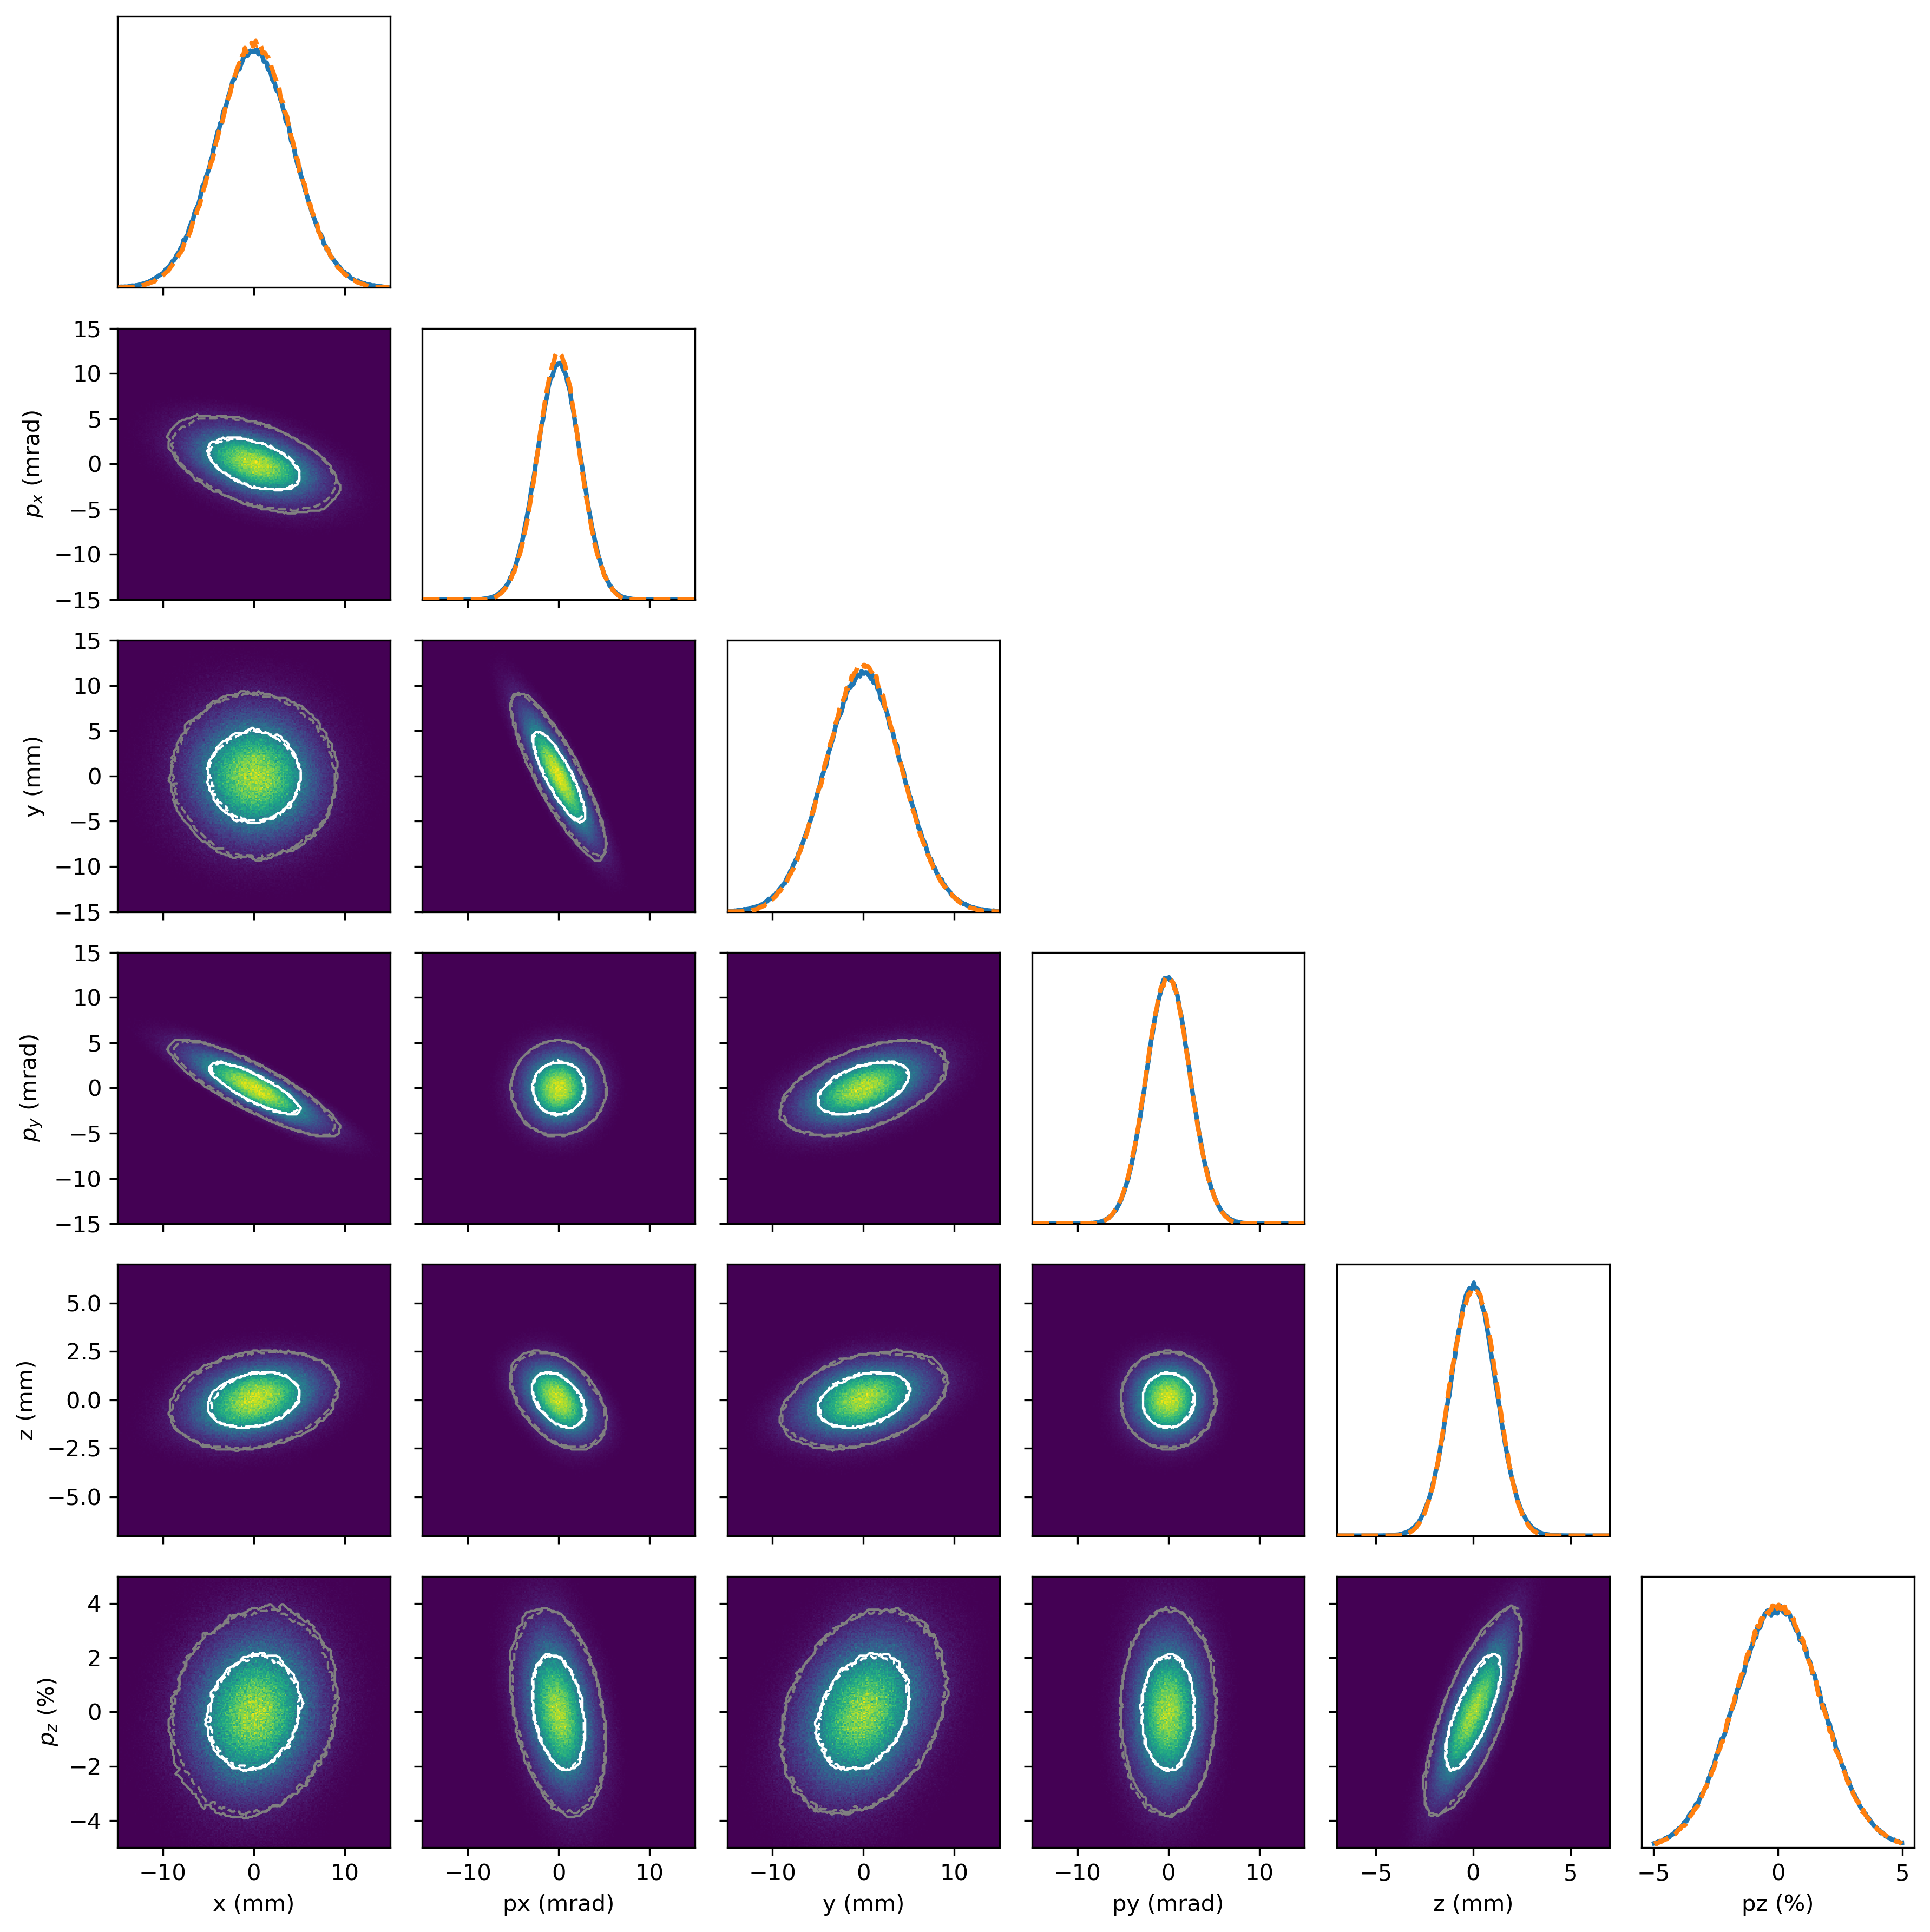

In [24]:
import torch
from stats import plot_projections_with_contours, show_cov_stats
import os

lims = np.array([[-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-7, 7],
                 [-5, 5]]) 

recn_dist = torch.load(os.path.join(save_dir, 'dist_3000.pt'))
recn_dist.data = recn_dist.data
fig,ax = plot_projections_with_contours(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50, 90],
    custom_lims=lims,
    contour_smoothing=0.25,
)

In [25]:
from stats import plot_projections_with_contours,show_cov_stats,get_cov,plot_cov_sigmas
frac = 0.9
cov_gt_frac = get_cov(gt_beam.numpy_particles(), beam_fraction=frac)
cov_reconstruction_frac = get_cov(recn_dist.numpy_particles(), beam_fraction=frac)

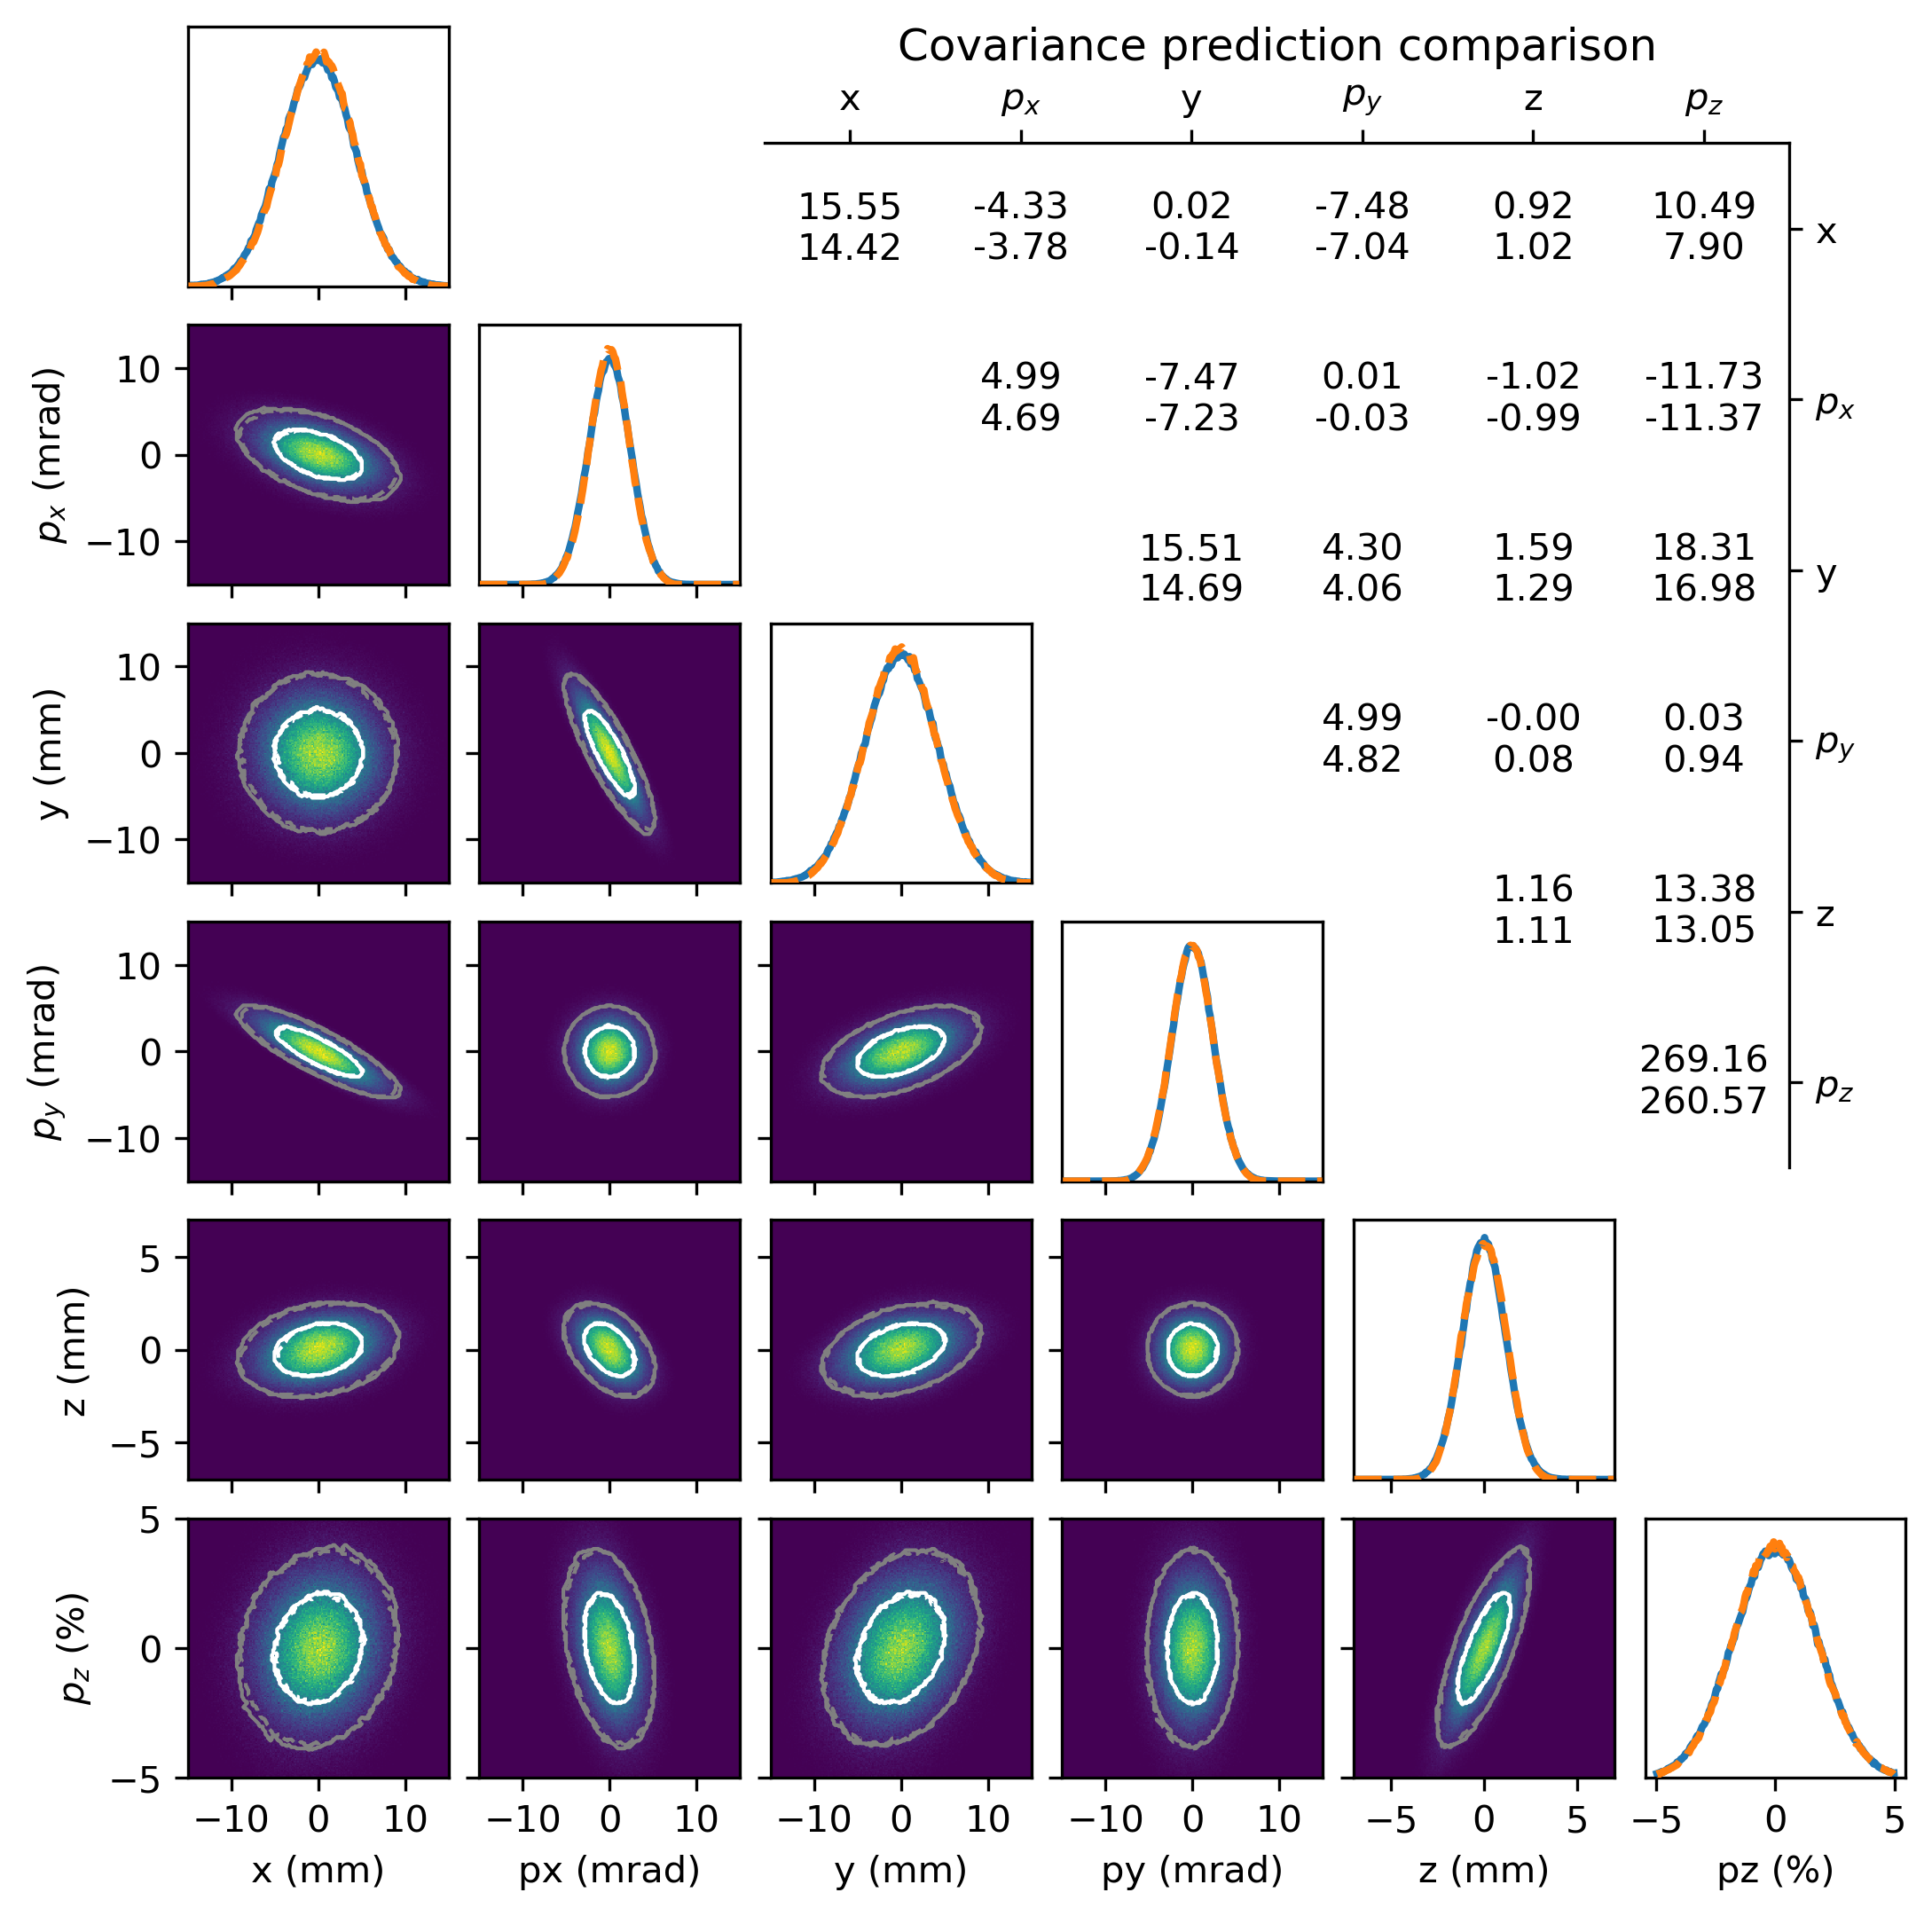

In [26]:
frac_error = cov_gt_frac - cov_reconstruction_frac
mask = np.tri(cov_sigmas.shape[0],k=-1)

mask = np.tri(frac_error.shape[0],k=-1)
frac_error = np.flipud(np.ma.array(frac_error, mask=mask))

manipulated_cov_gt = np.flipud(cov_gt_frac).T
manipulated_cov_recon = np.flipud(cov_reconstruction_frac).T


def plot_cov_sigmas(frac_error, fig=None):
    coords = ('x', '$p_x$', 'y', '$p_y$', 'z', '$p_z$')
    
    if fig is None:
        fig, ax = plt.subplots()
    else:
        center = 0.375
        cax_width = 0.025
        buffer = 0.05
        ax_width = 1-center-cax_width - buffer
        ax = fig.add_axes([center, center, ax_width, ax_width],zorder=0)
        #cax = fig.add_axes([center + ax_width + buffer, center, cax_width, ax_width],zorder=0)
        
    c = ax.pcolormesh(manipulated_cov_gt, cmap='seismic', vmin=-100, vmax=100, alpha=0.0)
    for (j,i), label in np.ndenumerate(cov_sigmas):
        if not frac_error.mask[i,j]:
            ax.text(i + 0.5, j + 0.5, f'{manipulated_cov_gt[i,j]*1e6:.2f}\n{manipulated_cov_recon[i,j]*1e6:.2f}', ha='center', va='center')
    #fig.colorbar(c,cax=cax,label="Covariance fractional error")
    ax.set_xticks(np.arange(len(coords))+0.5, labels=coords)
    ax.set_yticks(np.arange(len(coords))+0.5, labels=coords[::-1])
    
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #fig.tight_layout()
    
    ax.set_title("Covariance prediction comparison")

    return fig, ax

fig, ax = plot_cov_sigmas(frac_error,fig)
a = fig.get_axes()[:-10]
for ele in a:
    ele.zorder=10

fig.set_size_inches(7,7)
fig.savefig("gaussian_reconstruction.png",dpi=300)
fig.savefig("gaussian_reconstruction.svg")
fig

In [ ]:
torch.cuda.empty_cache()